<a href="https://colab.research.google.com/github/ricktorzynski/tensorflow-drupal/blob/main/tensorflow_drupal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Recommender System Using Drupal and TensorFlow.js
Adapted from *Build, Train, and Deploy a Book Recommender System Using Keras, TensorFlow.js, Node.js, and Firebase (Part 1)*, https://heartbeat.fritz.ai/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7.  Instead of using Node.js and Firebase, I will be using Drupal 9, the Component module, and the TensorFlow.js module.

The loading of the data, preprocessing the data, model building and model training will be done using Colab (or Jupyter Notebook), and the model will be exported and used by Drupal to do inference using TensorFlow.js.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

import tensorflow.keras as tf


Read the data downloaded from [Zygmuntz's Github repository](https://github.com/zygmuntz/goodbooks-10k) After downloading these csv files, you must upload them to Colab in a directory called book-data.  They will be removed when you stop or restart the kernel.

In [3]:
ratings_df = pd.read_csv("book-data/ratings.csv")
books_df = pd.read_csv("book-data/books.csv")

Display the first few lines of the ratings csv file.


In [4]:
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
books_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [6]:
print(ratings_df.shape)
print(ratings_df.user_id.nunique())
print(ratings_df.book_id.nunique())
ratings_df.isna().sum()

(5976479, 3)
53424
10000


user_id    0
book_id    0
rating     0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (4781183, 3)
Shape of test data: (1195296, 3)


In [8]:
#Get the number of unique entities in books and users columns
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [9]:
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,30)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,30)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(300, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [10]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        300030      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        1602750     input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=10, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/10
74706/74706 [==============================] - 661s 9ms/step - loss: 0.7788 - val_loss: 0.7380
Epoch 2/10
74706/74706 [==============================] - 599s 8ms/step - loss: 0.7098 - val_loss: 0.7067
Epoch 3/10
74706/74706 [==============================] - 570s 8ms/step - loss: 0.6737 - val_loss: 0.6879
Epoch 4/10
74706/74706 [==============================] - 597s 8ms/step - loss: 0.6459 - val_loss: 0.6791
Epoch 5/10
74706/74706 [==============================] - 637s 9ms/step - loss: 0.6227 - val_loss: 0.6776
Epoch 6/10
74706/74706 [==============================] - 580s 8ms/step - loss: 0.6021 - val_loss: 0.6759
Epoch 7/10
74706/74706 [==============================] - 595s 8ms/step - loss: 0.5827 - val_loss: 0.6819
Epoch 8/10
74706/74706 [==============================] - 641s 9ms/step - loss: 0.5649 - val_loss: 0.6855
Epoch 9/10
74706/74706 [==============================] - 642s 9ms/step - loss: 0.5488 - val_loss: 0.6881
Epoch 10/10
74706/74706 [=====================

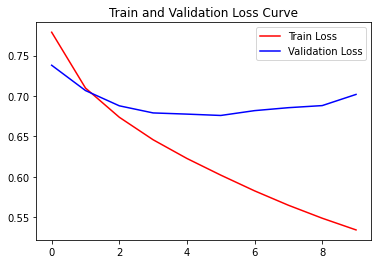

In [12]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

Save the model. This saves the model as a Tensorflow / Keras model. Note this format, as you’ll be referencing it during model conversion in the next tutorial.

In [13]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model/assets
